# 서울시 따릉이 공유 자전거 수요 예측 - AutoGluon

이 노트북에서는 AutoGluon을 활용하여 서울시 공유 자전거(따릉이) 수요를 예측합니다.

## 목차
1. 데이터 로드 및 탐색
2. 컬럼별 데이터 분석 및 시각화
3. 전처리
4. 특성 엔지니어링
5. 모델링 (AutoGluon)
6. 앙상블
7. 모델 비교 평가
8. submission.csv 파일 생성

## 1. 데이터 로드 및 탐색

In [65]:
import matplotlib as mpl
print(mpl.get_cachedir()) # 출력된 경로의 폴더를 삭제 후 커널 재시작

C:\Users\park0\.matplotlib


In [66]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

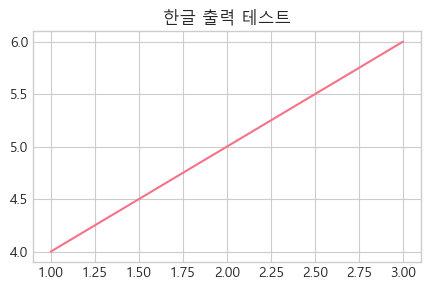

In [67]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 윈도우 폰트 경로 설정 (일반적으로 이 경로에 위치합니다)
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_prop = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rc('font', family=font_prop)
plt.rcParams['axes.unicode_minus'] = False

# 테스트
plt.figure(figsize=(5,3))
plt.title('한글 출력 테스트')
plt.plot([1, 2, 3], [4, 5, 6])
plt.show()

In [68]:
import os 

os.getcwd()

'c:\\Users\\park0\\github\\sklearn-est15th\\seoulBike'

In [69]:
# 데이터 로드
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

print(f'Train 데이터 크기: {train.shape}')
print(f'Test 데이터 크기: {test.shape}')
print(f'Submission 데이터 크기: {submission.shape}')

Train 데이터 크기: (1459, 11)
Test 데이터 크기: (715, 10)
Submission 데이터 크기: (715, 2)


In [70]:
# 데이터 확인
print('=== Train 데이터 상위 5개 ===' )
display(train.head())

print('\n=== Test 데이터 상위 5개 ===')
display(test.head())

=== Train 데이터 상위 5개 ===


,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0



=== Test 데이터 상위 5개 ===


,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


In [71]:
# 데이터 정보 확인
print('=== Train 데이터 정보 ===')
train.info()

=== Train 데이터 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [72]:
# 기술 통계량
print('=== Train 데이터 기술 통계량 ===')
train.describe()

=== Train 데이터 기술 통계량 ===


,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


In [73]:
# 결측치 확인
print('=== Train 결측치 ===' )
print(train.isnull().sum())
print(f'\n결측치 비율(%):')
print((train.isnull().sum() / len(train) * 100).round(2))

=== Train 결측치 ===
id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

결측치 비율(%):
id                        0.00
hour                      0.00
hour_bef_temperature      0.14
hour_bef_precipitation    0.14
hour_bef_windspeed        0.62
hour_bef_humidity         0.14
hour_bef_visibility       0.14
hour_bef_ozone            5.21
hour_bef_pm10             6.17
hour_bef_pm2.5            8.02
count                     0.00
dtype: float64


In [74]:
print('=== Test 결측치 ===')
print(test.isnull().sum())
print(f'\n결측치 비율(%):')
print((test.isnull().sum() / len(test) * 100).round(2))

=== Test 결측치 ===
id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

결측치 비율(%):
id                        0.00
hour                      0.00
hour_bef_temperature      0.14
hour_bef_precipitation    0.14
hour_bef_windspeed        0.14
hour_bef_humidity         0.14
hour_bef_visibility       0.14
hour_bef_ozone            4.90
hour_bef_pm10             5.17
hour_bef_pm2.5            5.03
dtype: float64


## 2. 컬럼별 데이터 분석 및 시각화

### 2.1 타겟 변수 (count) 분석

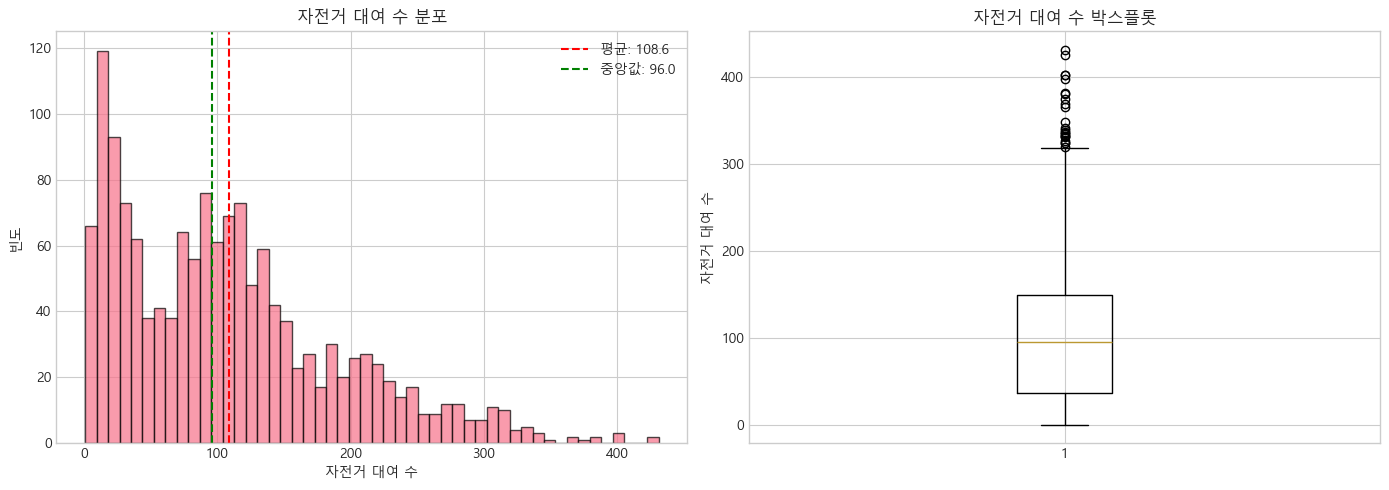

자전거 대여 수 통계:
- 평균: 108.56
- 중앙값: 96.00
- 표준편차: 82.63
- 최소값: 1
- 최대값: 431
- 왜도(Skewness): 0.91
- 첨도(Kurtosis): 0.46


In [75]:
# 타겟 변수 분포
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램
axes[0].hist(train['count'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('자전거 대여 수')
axes[0].set_ylabel('빈도')
axes[0].set_title('자전거 대여 수 분포')
axes[0].axvline(train['count'].mean(), color='red', linestyle='--', label=f'평균: {train["count"].mean():.1f}')
axes[0].axvline(train['count'].median(), color='green', linestyle='--', label=f'중앙값: {train["count"].median():.1f}')
axes[0].legend()

# 박스플롯
axes[1].boxplot(train['count'])
axes[1].set_ylabel('자전거 대여 수')
axes[1].set_title('자전거 대여 수 박스플롯')

plt.tight_layout()
plt.show()

print(f'자전거 대여 수 통계:')
print(f'- 평균: {train["count"].mean():.2f}')
print(f'- 중앙값: {train["count"].median():.2f}')
print(f'- 표준편차: {train["count"].std():.2f}')
print(f'- 최소값: {train["count"].min():.0f}')
print(f'- 최대값: {train["count"].max():.0f}')
print(f'- 왜도(Skewness): {train["count"].skew():.2f}')
print(f'- 첨도(Kurtosis): {train["count"].kurtosis():.2f}')

### 2.2 시간(hour) 분석

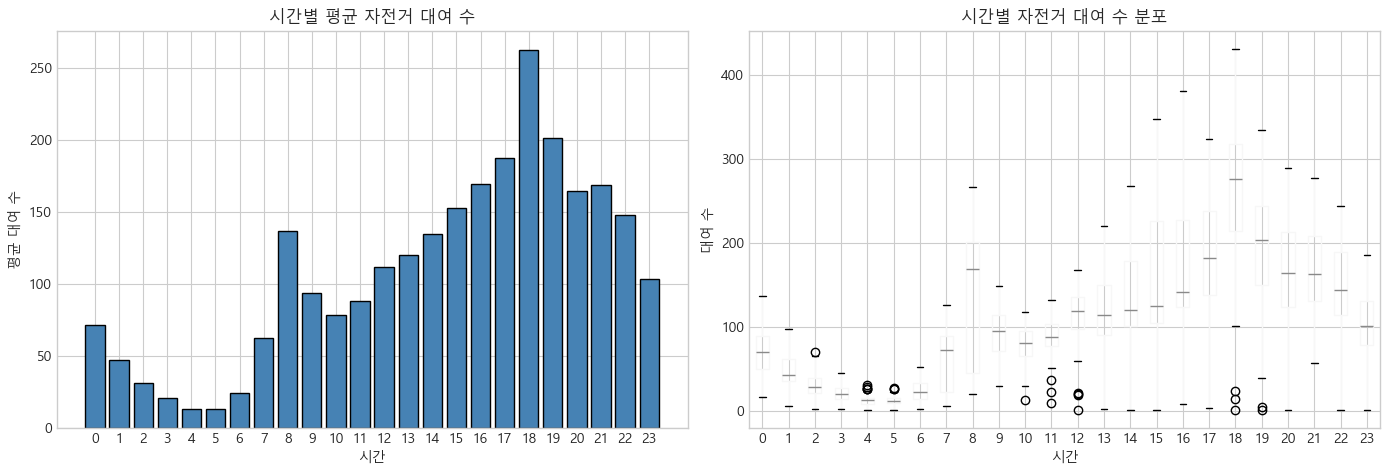

In [76]:
# 시간별 자전거 대여 수
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 시간별 평균 대여 수
hourly_mean = train.groupby('hour')['count'].mean()
axes[0].bar(hourly_mean.index, hourly_mean.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('시간')
axes[0].set_ylabel('평균 대여 수')
axes[0].set_title('시간별 평균 자전거 대여 수')
axes[0].set_xticks(range(24))

# 시간별 박스플롯
train.boxplot(column='count', by='hour', ax=axes[1])
axes[1].set_xlabel('시간')
axes[1].set_ylabel('대여 수')
axes[1].set_title('시간별 자전거 대여 수 분포')
plt.suptitle('')

plt.tight_layout()
plt.show()

### 2.3 기상 변수 분석

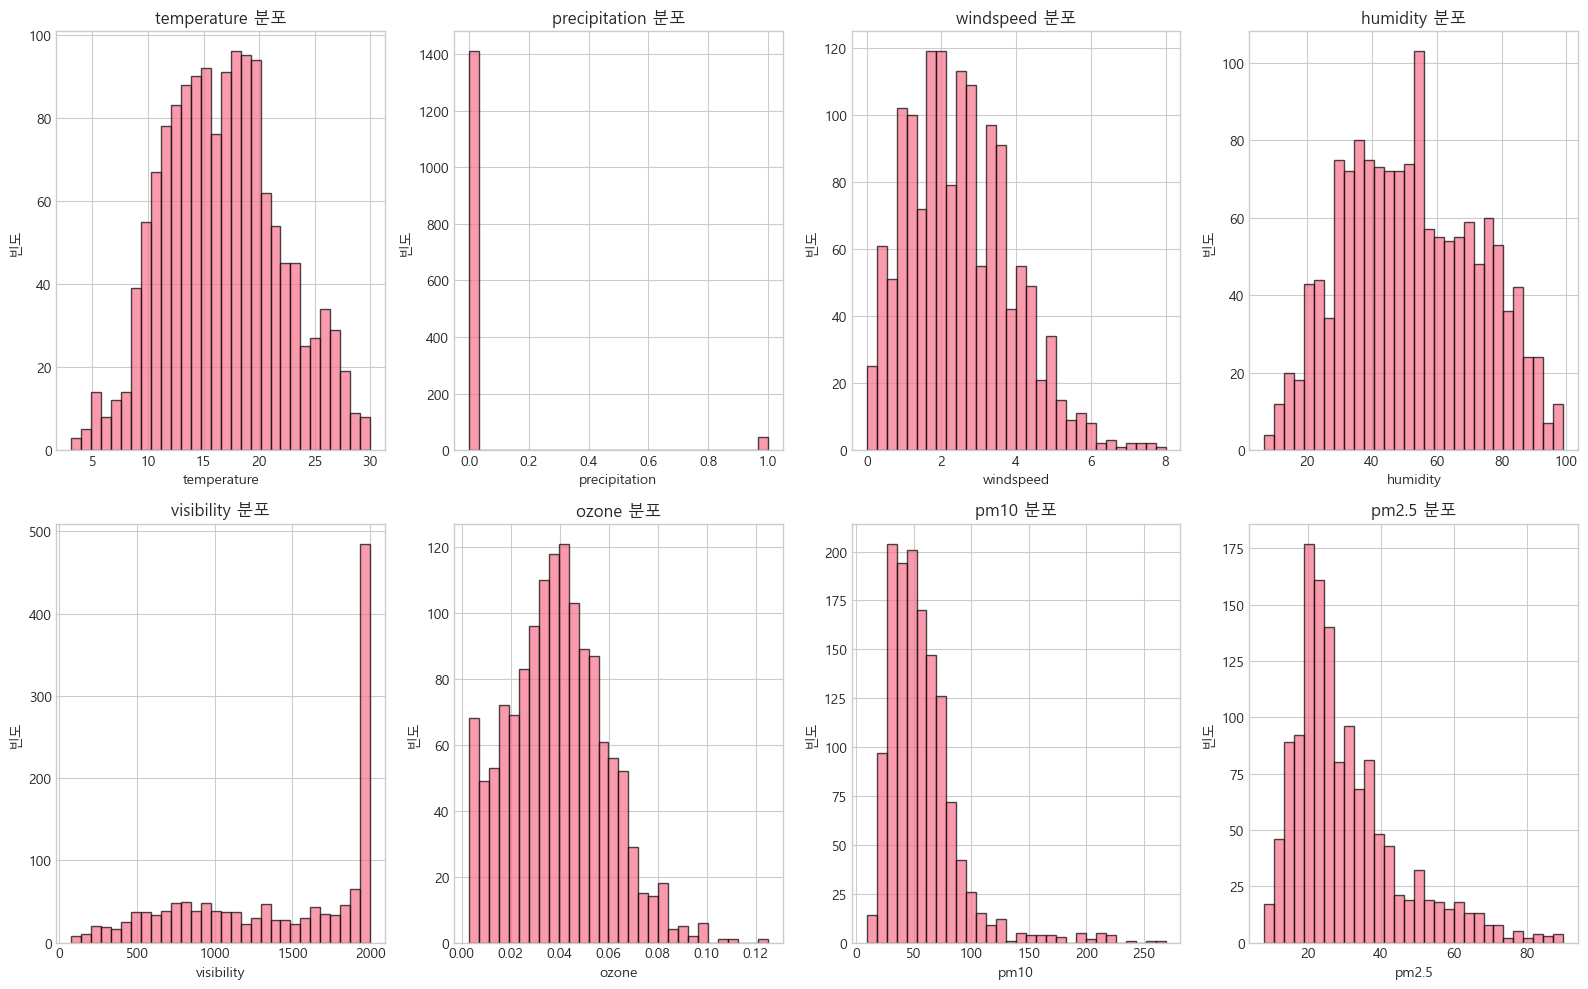

In [77]:
# 기상 변수 목록
weather_cols = ['hour_bef_temperature', 'hour_bef_precipitation', 'hour_bef_windspeed', 
                'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone', 
                'hour_bef_pm10', 'hour_bef_pm2.5']

# 각 기상 변수의 분포
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(weather_cols):
    axes[i].hist(train[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel(col.replace('hour_bef_', ''))
    axes[i].set_ylabel('빈도')
    axes[i].set_title(f'{col.replace("hour_bef_", "")} 분포')

plt.tight_layout()
plt.show()

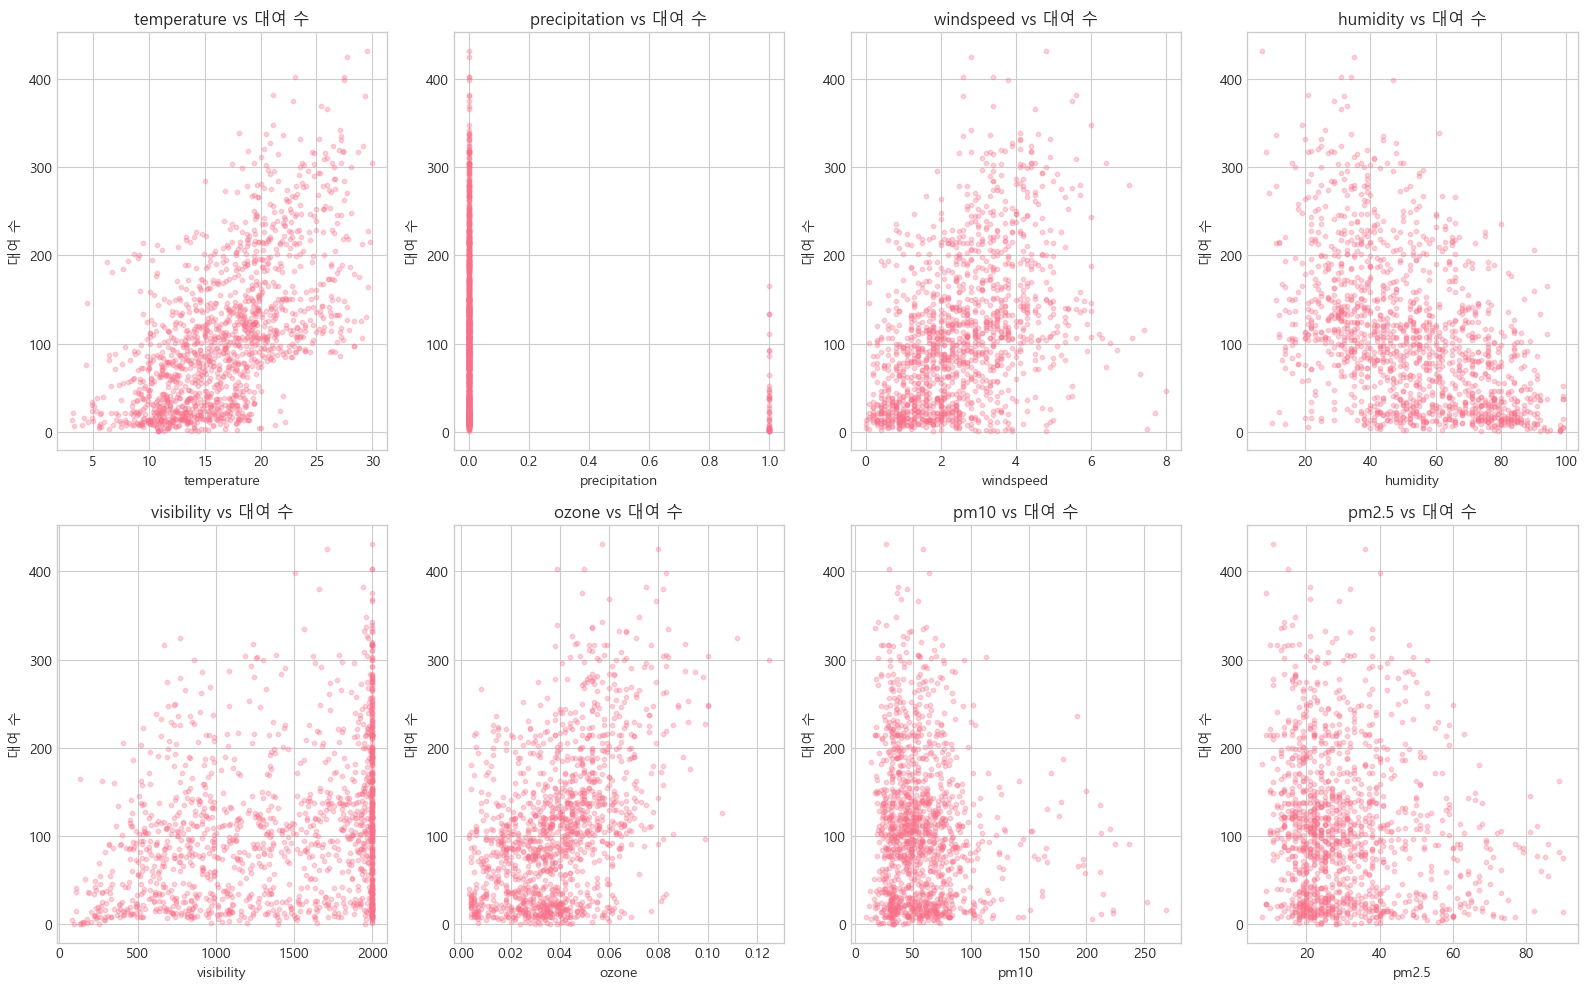

In [78]:
# 기상 변수와 대여 수의 관계 (산점도)
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(weather_cols):
    axes[i].scatter(train[col], train['count'], alpha=0.3, s=10)
    axes[i].set_xlabel(col.replace('hour_bef_', ''))
    axes[i].set_ylabel('대여 수')
    axes[i].set_title(f'{col.replace("hour_bef_", "")} vs 대여 수')

plt.tight_layout()
plt.show()

### 2.4 상관관계 분석

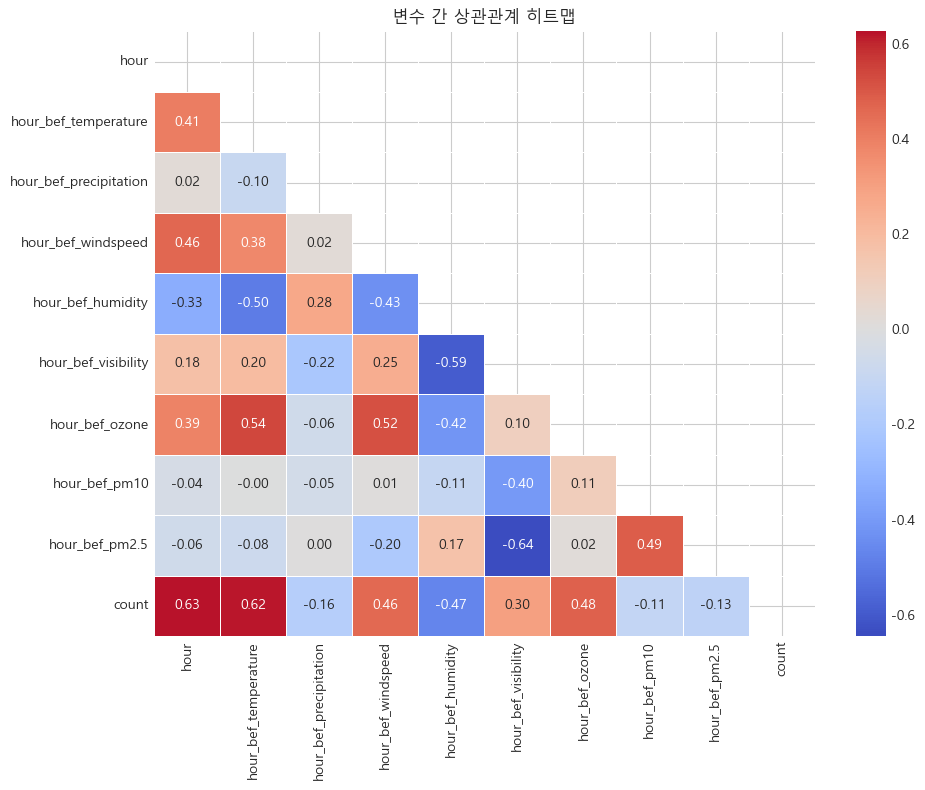


=== 타겟 변수(count)와의 상관관계 ===
count                     1.000000
hour                      0.626047
hour_bef_temperature      0.619404
hour_bef_ozone            0.477614
hour_bef_windspeed        0.459906
hour_bef_visibility       0.299094
hour_bef_pm10            -0.114288
hour_bef_pm2.5           -0.134293
hour_bef_precipitation   -0.163985
hour_bef_humidity        -0.471142
Name: count, dtype: float64


In [79]:
# 상관관계 히트맵
plt.figure(figsize=(10, 8))
correlation_matrix = train.drop('id', axis=1).corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, linewidths=0.5)
plt.title('변수 간 상관관계 히트맵')
plt.tight_layout()
plt.show()

# count와의 상관관계
print('\n=== 타겟 변수(count)와의 상관관계 ===')
print(correlation_matrix['count'].sort_values(ascending=False))

### 2.5 강수량 분석

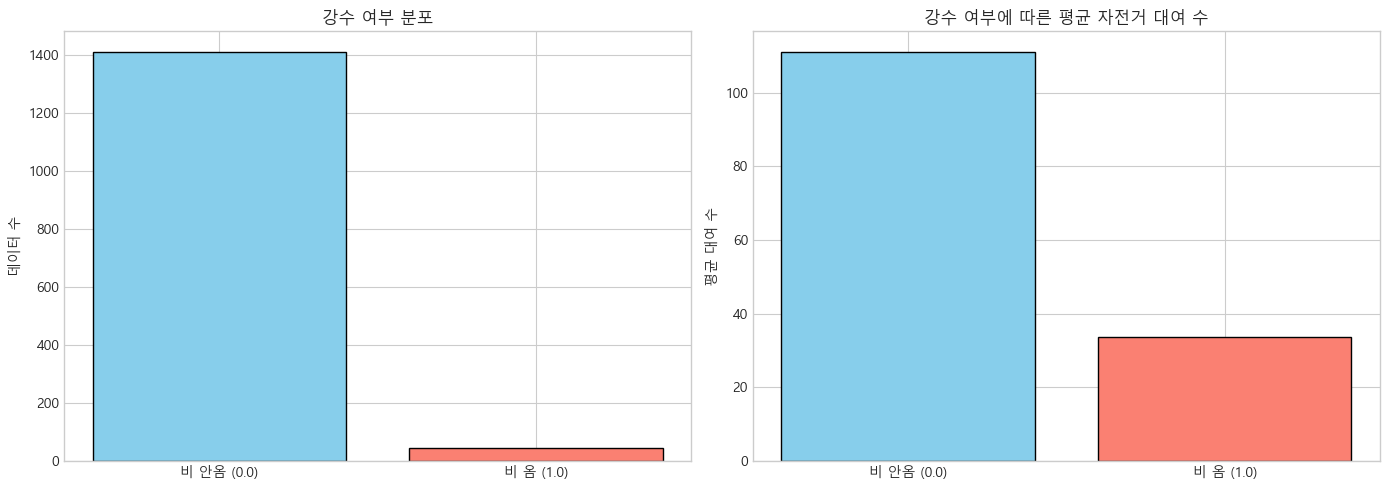

In [80]:
# 강수 여부에 따른 대여 수 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 강수 여부 분포
rain_counts = train['hour_bef_precipitation'].value_counts()
axes[0].bar(['비 안옴 (0.0)', '비 옴 (1.0)'], [rain_counts.get(0.0, 0), rain_counts.get(1.0, 0)], 
           color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_ylabel('데이터 수')
axes[0].set_title('강수 여부 분포')

# 강수 여부별 평균 대여 수
rain_mean = train.groupby('hour_bef_precipitation')['count'].mean()
axes[1].bar(['비 안옴 (0.0)', '비 옴 (1.0)'], [rain_mean.get(0.0, 0), rain_mean.get(1.0, 0)],
           color=['skyblue', 'salmon'], edgecolor='black')
axes[1].set_ylabel('평균 대여 수')
axes[1].set_title('강수 여부에 따른 평균 자전거 대여 수')

plt.tight_layout()
plt.show()

## 3. 전처리

In [81]:
# 데이터 복사
train_df = train.copy()
test_df = test.copy()

print(f'Train 결측치 개수:')
print(train_df.isnull().sum())
print(f'\nTest 결측치 개수:')
print(test_df.isnull().sum())

Train 결측치 개수:
id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

Test 결측치 개수:
id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64


In [82]:
# 결측치 처리 함수
def fill_missing_values(df):
    df_filled = df.copy()
    
    # 각 컬럼별 결측치 처리 (시간별 평균으로 대체)
    numeric_cols = df_filled.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in ['id', 'count']]
    
    for col in numeric_cols:
        if df_filled[col].isnull().sum() > 0:
            # 시간별 평균으로 결측치 대체
            hour_mean = df_filled.groupby('hour')[col].transform('mean')
            df_filled[col] = df_filled[col].fillna(hour_mean)
            # 여전히 결측치가 있다면 전체 평균으로 대체
            df_filled[col] = df_filled[col].fillna(df_filled[col].mean())
    
    return df_filled

# 결측치 처리 적용
train_df = fill_missing_values(train_df)
test_df = fill_missing_values(test_df)

print('결측치 처리 후:')
print(f'Train 결측치: {train_df.isnull().sum().sum()}')
print(f'Test 결측치: {test_df.isnull().sum().sum()}')

결측치 처리 후:
Train 결측치: 0
Test 결측치: 0


In [83]:
# 이상치 확인 및 처리
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# 주요 변수의 이상치 확인
print('=== 이상치 분석 ===')
for col in weather_cols:
    outliers, lb, ub = detect_outliers_iqr(train_df, col)
    if len(outliers) > 0:
        print(f'{col}: {len(outliers)}개 이상치 (범위: {lb:.2f} ~ {ub:.2f})')

=== 이상치 분석 ===
hour_bef_precipitation: 48개 이상치 (범위: 0.00 ~ 0.00)
hour_bef_windspeed: 9개 이상치 (범위: -1.60 ~ 6.40)
hour_bef_ozone: 16개 이상치 (범위: -0.01 ~ 0.09)
hour_bef_pm10: 59개 이상치 (범위: -9.50 ~ 114.50)
hour_bef_pm2.5: 88개 이상치 (범위: -1.50 ~ 58.50)


In [84]:
print(len(train_df.columns))
len(test_df.columns)

11


10

## 4. 특성 엔지니어링

In [85]:
def create_features(df):
    df_fe = df.copy()
    
    # 시간 관련 특성
    # 출퇴근 시간 여부 (7-9시, 18-20시)
    df_fe['is_rush_hour'] = ((df_fe['hour'] >= 7) & (df_fe['hour'] <= 9) | 
                            (df_fe['hour'] >= 18) & (df_fe['hour'] <= 20)).astype(int)
    
    # [추가] 출퇴근 시간 세분화
    df_fe['is_morning_rush'] = ((df_fe['hour'] >= 7) & (df_fe['hour'] <= 9)).astype(int)
    df_fe['is_evening_rush'] = ((df_fe['hour'] >= 18) & (df_fe['hour'] <= 20)).astype(int)
    
    # [추가] 점심 시간
    df_fe['is_lunch_time'] = ((df_fe['hour'] >= 12) & (df_fe['hour'] <= 13)).astype(int)
    
    # [추가] 심야 시간
    df_fe['is_night'] = ((df_fe['hour'] >= 23) | (df_fe['hour'] <= 5)).astype(int)
    
    # 낮/밤 구분 (6시-18시: 낮)
    df_fe['is_daytime'] = ((df_fe['hour'] >= 6) & (df_fe['hour'] < 18)).astype(int)
    
    # 시간대 구분 (새벽/아침/점심/저녁/밤)
    def get_time_period(hour):
        if hour < 6:
            return 0  # 새벽
        elif hour < 12:
            return 1  # 아침
        elif hour < 14:
            return 2  # 점심
        elif hour < 18:
            return 3  # 오후
        elif hour < 22:
            return 4  # 저녁
        else:
            return 5  # 밤
    
    df_fe['time_period'] = df_fe['hour'].apply(get_time_period)
    
    # 시간의 주기적 특성 (sin/cos 변환)
    df_fe['hour_sin'] = np.sin(2 * np.pi * df_fe['hour'] / 24)
    df_fe['hour_cos'] = np.cos(2 * np.pi * df_fe['hour'] / 24)
    
    # 기상 관련 특성
    # 체감온도 근사 (온도, 습도, 풍속 고려)
    df_fe['feels_like'] = df_fe['hour_bef_temperature'] - \
                         0.55 * (1 - df_fe['hour_bef_humidity']/100) * \
                         (df_fe['hour_bef_temperature'] - 14.5)
    
    # 불쾌지수
    df_fe['discomfort_index'] = 0.81 * df_fe['hour_bef_temperature'] + \
                                0.01 * df_fe['hour_bef_humidity'] * \
                                (0.99 * df_fe['hour_bef_temperature'] - 14.3) + 46.3
    
    # 날씨 좋음 지표 (비 안오고, 적당한 온도, 낮은 미세먼지)
    df_fe['good_weather'] = ((df_fe['hour_bef_precipitation'] == 0) & 
                            (df_fe['hour_bef_temperature'] >= 10) & 
                            (df_fe['hour_bef_temperature'] <= 25) &
                            (df_fe['hour_bef_pm10'] < 80)).astype(int)
    
    # [추가] 자전거 타기 좋은 조건 점수화 (bike_score)
    df_fe['bike_score'] = (
        (df_fe['hour_bef_temperature'].between(15, 25)).astype(int) * 2 +
        (df_fe['hour_bef_humidity'] < 70).astype(int) +
        (df_fe['hour_bef_precipitation'] == 0).astype(int) * 3 +
        (df_fe['hour_bef_pm10'] < 50).astype(int) +
        (df_fe['hour_bef_windspeed'] < 4).astype(int)
    )
    
    # [추가] 악천후 지표
    df_fe['bad_weather'] = (
        (df_fe['hour_bef_precipitation'] == 1) |
        (df_fe['hour_bef_visibility'] < 500) |
        (df_fe['hour_bef_pm10'] > 100)
    ).astype(int)
    
    # [추가] 최적 온도(20도)와의 거리
    df_fe['temp_diff_from_optimal'] = abs(df_fe['hour_bef_temperature'] - 20)
    
    # [추가] 온도 제곱 (비선형 관계 포착)
    df_fe['temp_squared'] = df_fe['hour_bef_temperature'] ** 2
    
    # [추가] 시야 확보 지표
    df_fe['visibility_score'] = (
        df_fe['hour_bef_visibility'] / 2000 - 
        df_fe['hour_bef_pm10'] / 100
    )
    
    # 대기질 지수 (PM10과 PM2.5의 가중 평균)
    df_fe['air_quality_index'] = (df_fe['hour_bef_pm10'] * 0.4 + 
                                  df_fe['hour_bef_pm2.5'] * 0.6)
    
    # 시정 그룹화
    df_fe['visibility_group'] = pd.cut(df_fe['hour_bef_visibility'], 
                                       bins=[0, 500, 1000, 1500, 2001],
                                       labels=[0, 1, 2, 3]).astype(int)
    
    # 온도 구간
    df_fe['temp_group'] = pd.cut(df_fe['hour_bef_temperature'],
                                 bins=[-10, 0, 10, 20, 30, 40],
                                 labels=[0, 1, 2, 3, 4]).astype(int)
    
    # 상호작용 특성
    df_fe['temp_humidity'] = df_fe['hour_bef_temperature'] * df_fe['hour_bef_humidity']
    df_fe['temp_wind'] = df_fe['hour_bef_temperature'] * df_fe['hour_bef_windspeed']
    
    return df_fe

# 특성 엔지니어링 적용
train_fe = create_features(train_df)
test_fe = create_features(test_df)

print(f'특성 엔지니어링 후 Train 컬럼 수: {train_fe.shape[1]}')
print(f'특성 엔지니어링 후 Test 컬럼 수: {test_fe.shape[1]}')
print(f'\n새로 생성된 특성들:')
new_features = [col for col in train_fe.columns if col not in train_df.columns]
print(new_features)

특성 엔지니어링 후 Train 컬럼 수: 33
특성 엔지니어링 후 Test 컬럼 수: 32

새로 생성된 특성들:
['is_rush_hour', 'is_morning_rush', 'is_evening_rush', 'is_lunch_time', 'is_night', 'is_daytime', 'time_period', 'hour_sin', 'hour_cos', 'feels_like', 'discomfort_index', 'good_weather', 'bike_score', 'bad_weather', 'temp_diff_from_optimal', 'temp_squared', 'visibility_score', 'air_quality_index', 'visibility_group', 'temp_group', 'temp_humidity', 'temp_wind']


In [86]:
# 새로 생성된 특성과 타겟 변수의 상관관계
print('=== 새로운 특성과 count의 상관관계 ===')
for feat in new_features:
    corr = train_fe[feat].corr(train_fe['count'])
    print(f'{feat}: {corr:.4f}')

=== 새로운 특성과 count의 상관관계 ===
is_rush_hour: 0.3151
is_morning_rush: -0.0506
is_evening_rush: 0.4630
is_lunch_time: 0.0269
is_night: -0.5084
is_daytime: 0.0555
time_period: 0.6334
hour_sin: -0.6812
hour_cos: -0.1689
feels_like: 0.5884
discomfort_index: 0.5881
good_weather: 0.0605
bike_score: 0.3074
bad_weather: -0.2514
temp_diff_from_optimal: -0.3423
temp_squared: 0.6272
visibility_score: 0.2427
air_quality_index: -0.1383
visibility_group: 0.2783
temp_group: 0.5444
temp_humidity: -0.0221
temp_wind: 0.6241


## 5. 모델링 (AutoGluon)

In [87]:
# AutoGluon 설치 확인 및 임포트
try:
    from autogluon.tabular import TabularPredictor
    print('AutoGluon 임포트 성공!')
except ImportError:
    print('AutoGluon이 설치되어 있지 않습니다.')
    print('설치 명령어: pip install autogluon')

AutoGluon 임포트 성공!


In [ ]:
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split

# 학습/검증 데이터 분리
X = train_fe.drop(['id', 'count'], axis=1)
y = train_fe['count']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 학습 데이터 준비 (로그 변환 제거 - 원래 스케일 사용)
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)

print(f'학습 데이터 크기: {train_data.shape}')
print(f'검증 데이터 크기: {val_data.shape}')

In [89]:
# cpu의 사용가능한 코어의 갯수 확인
import os
num_cpus = os.cpu_count()
num_cpus = int(num_cpus *(2/3))
num_cpus

21

### AutoGluon presets 설명:

| Preset | 설명 | 학습 시간 | 성능 |
|--------|------|----------|------|
| `best_quality` | 최고 성능, 여러 모델 앙상블 | 가장 김 | 최고 |
| `high_quality` | 높은 성능, 적당한 시간 | 김 | 높음 |
| `good_quality` | 적당한 성능 | 중간 | 중간 |
| `medium_quality` | 빠른 학습, 적당한 성능 | 짧음 | 중간 |
| `optimize_for_deployment` | 배포 최적화 | 짧음 | 중간 |

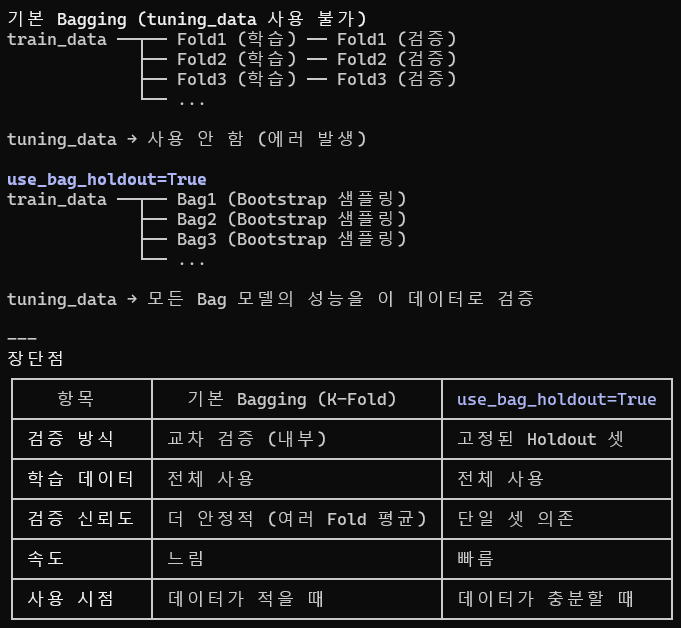

In [ ]:
import random

# 기본 단위 : 초(sec)
setTime = 30 * 60  # [변경] 15분 → 30분으로 증가

# 파이썬 및 넘파이 시드 고정
random.seed(42)
np.random.seed(42)

# AutoGluon 모델 학습
predictor = TabularPredictor(
    label='count',
    problem_type='regression',
    eval_metric='root_mean_squared_error',
    path='./autogluon_models'
)

# 모델 학습 (다양한 모델 앙상블)
predictor.fit(
    num_cpus=num_cpus,
    train_data=train_data,
    tuning_data=val_data,
    time_limit=setTime,  # 30분
    presets='best_quality',  # 최고 품질 설정
    use_bag_holdout=True,  # bagged mode에서 tuning_data를 holdout으로 사용
    excluded_model_types=['NN_TORCH', 'FASTAI'],
    verbosity=2
)

Verbosity: 2 (Standard Logging)
	Failed to import torch or check CUDA availability!Please ensure you have the correct version of PyTorch installed by running `pip install -U torch`
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26200
CPU Count:          32
Pytorch Version:    Can't import torch
CUDA Version:       Can't get cuda version from torch
Memory Avail:       231.52 GB / 255.84 GB (90.5%)
Disk Space Avail:   1651.39 GB / 1906.77 GB (86.6%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models to "c:\Users\p

In [ ]:
# 검증 데이터 성능 평가
val_predictions = predictor.predict(val_data.drop('count', axis=1))

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
mae = mean_absolute_error(y_val, val_predictions)
r2 = r2_score(y_val, val_predictions)

print('=== 검증 데이터 성능 ===')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R2 Score: {r2:.4f}')

In [ ]:
# 검증 데이터 성능 평가
val_predictions_log = predictor.predict(val_data.drop('count', axis=1))

# [추가] 로그 역변환 (원래 스케일로 복원)
val_predictions = np.expm1(val_predictions_log)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 원래 스케일(y_val)과 비교
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
mae = mean_absolute_error(y_val, val_predictions)
r2 = r2_score(y_val, val_predictions)

print('=== 검증 데이터 성능 (원래 스케일) ===')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R2 Score: {r2:.4f}')

In [ ]:
# 특성 중요도
print('=== 특성 중요도 ===')
feature_importance = predictor.feature_importance(val_data)
display(feature_importance.head(20))

# 특성 중요도 시각화
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('중요도')
plt.title('AutoGluon 특성 중요도 (상위 15개)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. 앙상블

In [ ]:
# 개별 모델 성능 비교
print('=== 개별 모델 성능 비교 ===')
model_results = {}
for model_name in predictor.model_names():
    try:
        pred = predictor.predict(val_data.drop('count', axis=1), model=model_name)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        model_results[model_name] = rmse
    except:
        pass

# 결과 정렬 및 출력
model_results_sorted = dict(sorted(model_results.items(), key=lambda x: x[1]))
for model, rmse in model_results_sorted.items():
    print(f'{model}: RMSE = {rmse:.4f}')

In [ ]:
# 개별 모델 성능 비교
print('=== 개별 모델 성능 비교 ===')
model_results = {}
for model_name in predictor.model_names():
    try:
        pred_log = predictor.predict(val_data.drop('count', axis=1), model=model_name)
        pred = np.expm1(pred_log)  # [추가] 로그 역변환
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        model_results[model_name] = rmse
    except:
        pass

# 결과 정렬 및 출력
model_results_sorted = dict(sorted(model_results.items(), key=lambda x: x[1]))
for model, rmse in model_results_sorted.items():
    print(f'{model}: RMSE = {rmse:.4f}')

In [ ]:
# 모델별 성능 시각화
plt.figure(figsize=(12, 6))
models = list(model_results_sorted.keys())[:10]  # 상위 10개
rmses = [model_results_sorted[m] for m in models]

plt.barh(range(len(models)), rmses, color='steelblue', edgecolor='black')
plt.yticks(range(len(models)), models)
plt.xlabel('RMSE (낮을수록 좋음)')
plt.title('모델별 RMSE 비교 (상위 10개)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 예측값 vs 실제값 비교
best_predictions = predictor.predict(val_data.drop('count', axis=1))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 산점도
axes[0].scatter(y_val, best_predictions, alpha=0.5, s=20)
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0].set_xlabel('실제 대여 수')
axes[0].set_ylabel('예측 대여 수')
axes[0].set_title('실제값 vs 예측값')

# 잔차 분포
residuals = y_val - best_predictions
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--')
axes[1].set_xlabel('잔차 (실제 - 예측)')
axes[1].set_ylabel('빈도')
axes[1].set_title('잔차 분포')

plt.tight_layout()
plt.show()

print(f'잔차 통계:')
print(f'- 평균: {residuals.mean():.4f}')
print(f'- 표준편차: {residuals.std():.4f}')

In [ ]:
# 최종 성능 요약
print('=' * 50)
print('AutoGluon 최종 성능 요약')
print('=' * 50)
print(f'\n최고 성능 모델: {predictor.model_best}')
print(f'\n적용된 개선사항:')
print(f'  - 추가 특성: bike_score, bad_weather, temp_squared 등')
print(f'  - 학습 시간: 30분')
print(f'\n검증 데이터 성능:')
print(f'  - RMSE: {rmse:.4f}')
print(f'  - MAE: {mae:.4f}')
print(f'  - R² Score: {r2:.4f}')
print('=' * 50)

In [ ]:
# 최종 성능 요약
print('=' * 50)
print('AutoGluon 최종 성능 요약')
print('=' * 50)
print(f'\n최고 성능 모델: {predictor.model_best}')
print(f'\n적용된 개선사항:')
print(f'  - 타겟 변수 로그 변환 (log1p)')
print(f'  - 추가 특성: bike_score, bad_weather, temp_squared 등')
print(f'  - 학습 시간: 30분')
print(f'\n검증 데이터 성능 (원래 스케일):')
print(f'  - RMSE: {rmse:.4f}')
print(f'  - MAE: {mae:.4f}')
print(f'  - R² Score: {r2:.4f}')
print('=' * 50)

# 테스트 데이터 예측
test_features = test_fe.drop('id', axis=1)
test_predictions = predictor.predict(test_features)

# 음수 예측값 처리 (대여 수는 음수가 될 수 없음)
test_predictions = np.maximum(test_predictions, 0)

print(f'테스트 예측값 통계:')
print(f'- 평균: {test_predictions.mean():.2f}')
print(f'- 중앙값: {np.median(test_predictions):.2f}')
print(f'- 최소값: {test_predictions.min():.2f}')
print(f'- 최대값: {test_predictions.max():.2f}')

In [ ]:
# 테스트 데이터 예측
test_features = test_fe.drop('id', axis=1)
test_predictions_log = predictor.predict(test_features)

# [추가] 로그 역변환 (원래 스케일로 복원)
test_predictions = np.expm1(test_predictions_log)

# 음수 예측값 처리 (대여 수는 음수가 될 수 없음)
test_predictions = np.maximum(test_predictions, 0)

print(f'테스트 예측값 통계:')
print(f'- 평균: {test_predictions.mean():.2f}')
print(f'- 중앙값: {np.median(test_predictions):.2f}')
print(f'- 최소값: {test_predictions.min():.2f}')
print(f'- 최대값: {test_predictions.max():.2f}')

In [ ]:
# submission 파일 생성
submission_df = pd.DataFrame({
    'id': test_fe['id'],
    'count': test_predictions
})

# 결과 확인
print('=== Submission 데이터 미리보기 ===')
display(submission_df.head(10))

# CSV 파일로 저장
submission_df.to_csv('./submission_autogluon.csv', index=False)
print(f'\n파일 저장 완료: ./submission_autogluon.csv')
print(f'제출 파일 크기: {submission_df.shape}')

In [ ]:
# 예측 분포 확인
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 학습 데이터 분포
axes[0].hist(train_fe['count'], bins=50, alpha=0.7, label='Train', edgecolor='black')
axes[0].set_xlabel('대여 수')
axes[0].set_ylabel('빈도')
axes[0].set_title('학습 데이터 분포')
axes[0].legend()

# 예측 분포
axes[1].hist(test_predictions, bins=50, alpha=0.7, label='Predictions', edgecolor='black', color='orange')
axes[1].set_xlabel('예측 대여 수')
axes[1].set_ylabel('빈도')
axes[1].set_title('테스트 예측 분포')
axes[1].legend()

plt.tight_layout()
plt.show()

## 완료!

AutoGluon을 사용하여 서울시 따릉이 자전거 수요 예측 모델을 구축하였습니다.

### 요약
- **데이터 분석**: 시간, 기상 변수들의 분포와 타겟 변수와의 관계 분석
- **전처리**: 결측치를 시간별 평균으로 대체
- **특성 엔지니어링**: 시간 관련 특성, 기상 관련 특성, 상호작용 특성 생성
- **모델링**: AutoGluon의 자동 모델 선택 및 하이퍼파라미터 튜닝
- **앙상블**: AutoGluon 내장 앙상블 기법 활용
- **평가**: RMSE, MAE, R² Score 기반 성능 평가
- **제출**: submission_autogluon.csv 파일 생성